# Installing necessary libraries

In [ ]:
! pip install pyathena

  Using cached pyathena-3.12.2-py3-none-any.whl.metadata (6.3 kB)
Using cached pyathena-3.12.2-py3-none-any.whl (75 kB)


In [ ]:
!pip install awswrangler

  Using cached awswrangler-3.11.0-py3-none-any.whl.metadata (17 kB)
Using cached awswrangler-3.11.0-py3-none-any.whl (379 kB)


In [ ]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.9 MB/s eta 0:00:00ta 0:00:01


## Importing necessary libraries

In [ ]:
from pyathena import connect

In [ ]:
import awswrangler as wr
import pandas as pd


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Converting InstantCart CSV dataset into Parquet

In [ ]:
# Defining S3 paths
csv_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/filtered_frequent_buyers_v1.csv"
parquet_output_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned/"

# Loading CSV from S3
df = pd.read_csv(csv_path)

# Converting and saving Parquet with Partitioning by 'department'
wr.s3.to_parquet(
    df=df,
    path=parquet_output_path,
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],  # Partitioning by department
    compression="snappy"  # Optimized compression for Athena
)

print("Dataset saved as partitioned Parquet files in S3.")

# Defining Glue Database & Table
database_name = "instacart_db"
table_name = "instacart_orders"

# Registering the Parquet Table in AWS Glue
wr.catalog.create_parquet_table(
    database=database_name,
    table=table_name,
    path=parquet_output_path,
    columns_types={
        "order_id": "bigint",
        "product_id": "bigint",
        "add_to_cart_order": "int",
        "reordered": "int",
        "user_id": "bigint",
        "product_name": "string",
        "aisle_id": "int",
        "department_id": "int",
        "aisle": "string",
        "department": "string"
    },
    partitions_types={"department": "string"},
    description="Partitioned Instacart orders dataset for optimized Athena queries."
)

print("Partitioned Parquet table registered in AWS Glue successfully.")


/opt/conda/lib/python3.11/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Dataset saved as partitioned Parquet files in S3.
Partitioned Parquet table registered in AWS Glue successfully.


# Setting up Database for InstantCart

In [ ]:
from pyathena import connect

# Defineing AWS Resources
bucket_name = "sagemaker-us-east-1-921916832724"
region = "us-east-1"
database_name = "instacart_db"
table_name = "instacart_orders"
s3_data_location = f"s3://{bucket_name}/data-lake/Project/partitioned/"  # Using partitioned dataset

# Defining Athena Staging Directory
s3_staging_dir = f"s3://{bucket_name}/athena/instacart_staging/"

# Creating Athena Connection
try:
    conn = connect(s3_staging_dir=s3_staging_dir, region_name=region)
    cursor = conn.cursor()
    print("Connected to Athena successfully.")
except Exception as e:
    print("Error connecting to Athena:", e)

# Creating Database
create_db_query = f"CREATE DATABASE IF NOT EXISTS {database_name}"
cursor.execute(create_db_query)
print(f"Database '{database_name}' created successfully!")

# Verifying Database Creation
cursor.execute("SHOW DATABASES")
databases = [row[0] for row in cursor.fetchall()]
if database_name in databases:
    print(f"Database '{database_name}' exists!")


Connected to Athena successfully.
Database 'instacart_db' created successfully!
Database 'instacart_db' exists!


# Creating Athena database

In [ ]:
create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
    order_id BIGINT,
    product_id BIGINT,
    add_to_cart_order INT,
    reordered INT,
    user_id BIGINT,
    product_name STRING,
    aisle_id INT,
    department_id INT,
    aisle STRING
)
PARTITIONED BY (department STRING)
STORED AS PARQUET
LOCATION '{s3_data_location}'
TBLPROPERTIES ('parquet.compression'='SNAPPY');
"""

# Execute Table Creation Query
cursor.execute(create_table_query)
print(f"Table '{table_name}' created successfully in database '{database_name}'.")

# Running MSCK REPAIR to Load Partitions
cursor.execute(f"MSCK REPAIR TABLE {database_name}.{table_name}")
print("Partitions updated successfully.")


Table 'instacart_orders' created successfully in database 'instacart_db'.
Partitions updated successfully.


In [ ]:
# Verifying that the table Exists
cursor.execute("SHOW TABLES")
tables = [row[0] for row in cursor.fetchall()]
if table_name in tables:
    print(f"Table '{table_name}' exists in Athena!")

# Running a Sample Query to Verify Data
test_query = f"SELECT * FROM {database_name}.{table_name} LIMIT 10;"
cursor.execute(test_query)
rows = cursor.fetchall()

print("Sample Query Results:")
for row in rows:
    print(row)

Sample Query Results:
(5, 40878, 11, 1, 156122, 'Macaroni And Cheese', 4, 9, 'instant foods', 'dry goods pasta')
(5, 46522, 23, 0, 156122, 'Spaghetti Pasta', 131, 9, 'dry pasta', 'dry goods pasta')
(58, 23375, 1, 1, 150647, 'Marinara Sauce', 9, 9, 'pasta sauce', 'dry goods pasta')
(88, 9366, 11, 0, 102020, 'Penne Rigate #41 Pasta', 131, 9, 'dry pasta', 'dry goods pasta')
(101, 37825, 11, 1, 18783, 'Organic Whole Wheat Fusilli', 131, 9, 'dry pasta', 'dry goods pasta')
(106, 18019, 12, 1, 161214, 'Macaroni & Cheese Dinner Original Flavor', 4, 9, 'instant foods', 'dry goods pasta')
(106, 14168, 14, 1, 161214, 'Penne Pasta', 131, 9, 'dry pasta', 'dry goods pasta')
(106, 12945, 23, 1, 161214, 'Signature Recipes Vodka Sauce Pasta Sauce', 9, 9, 'pasta sauce', 'dry goods pasta')
(125, 43249, 14, 1, 66104, "Organic Bernie's Farm Macaroni & Cheese", 4, 9, 'instant foods', 'dry goods pasta')
(125, 39619, 15, 1, 66104, 'Organic Tomato Basil Pasta Sauce', 9, 9, 'pasta sauce', 'dry goods pasta')


# Exploratory Data Analysis

## Checking the Total Orders and Unique Users

In [ ]:
# Defining AWS Athena connection
bucket_name = "sagemaker-us-east-1-921916832724"
region = "us-east-1"
database_name = "instacart_db"
table_name = "instacart_orders"

# Establishing Athena connection
conn = connect(s3_staging_dir=f"s3://{bucket_name}/athena/instacart_staging/", region_name=region)
cursor = conn.cursor()

# First Query: Total Orders & Unique Users
query = f"""
SELECT
    COUNT(DISTINCT order_id) AS total_orders,
    COUNT(DISTINCT user_id) AS unique_users
FROM {database_name}.{table_name};
"""

# Executing query
cursor.execute(query)
rows = cursor.fetchall()

# Printing results
print("Total Orders & Unique Users:")
for row in rows:
    print(row)



Total Orders & Unique Users:
(562019, 11033)


## Top 10 Most Ordered Products


In [ ]:
query = f"""
SELECT product_name, COUNT(*) AS total_orders
FROM {database_name}.{table_name}
GROUP BY product_name
ORDER BY total_orders DESC
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Top 10 Most Ordered Products:")
for row in rows:
    print(row)


Top 10 Most Ordered Products:
('Banana', 129758)
('Bag of Organic Bananas', 117352)
('Organic Strawberries', 98600)
('Organic Hass Avocado', 78967)
('Organic Baby Spinach', 73601)
('Organic Raspberries', 53856)
('Organic Avocado', 48595)
('Organic Whole Milk', 48219)
('Limes', 43114)
('Large Lemon', 41812)


/tmp/ipykernel_22/4294567563.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total Orders", y="Product Name", data=df_products, palette="viridis")


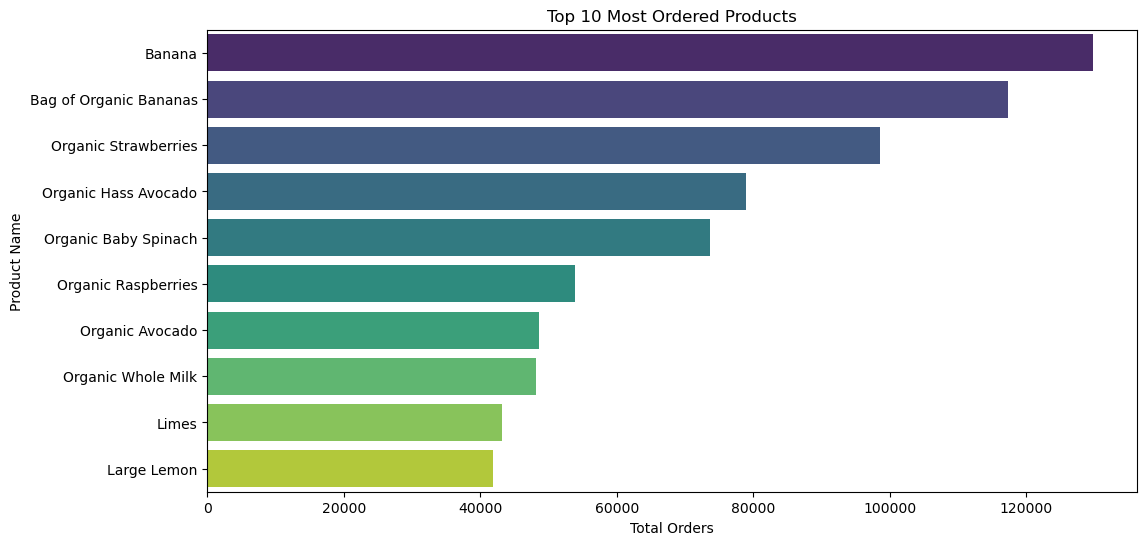

In [ ]:
# ===========================
#  Bar Chart: Top 10 Most Ordered Products
# ===========================

products = ["Banana", "Bag of Organic Bananas", "Organic Strawberries", "Organic Hass Avocado",
            "Organic Baby Spinach", "Organic Raspberries", "Organic Avocado", "Organic Whole Milk",
            "Limes", "Large Lemon"]
total_orders = [129758, 117352, 98600, 78967, 73601, 53856, 48595, 48219, 43114, 41812]

# Creating DataFrame
df_products = pd.DataFrame({"Product Name": products, "Total Orders": total_orders})

# Plotting Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Orders", y="Product Name", data=df_products, palette="viridis")
plt.xlabel("Total Orders")
plt.ylabel("Product Name")
plt.title("Top 10 Most Ordered Products")
plt.show()


### Insights

- Bananas are the most ordered item with 129,758 orders.
- Organic produce is extremely popular. Where 7 out of 10 items are organic.
- Dairy products like Whole Milk rank in the Top 10.
- Cirtrus fruits like Limes and Lemons are in high demand.

## Reorder Rate per Product

In [ ]:
query = f"""
SELECT
    product_name,
    COUNT(*) AS total_orders,
    SUM(reordered) AS total_reorders,
    ROUND(100.0 * SUM(reordered) / COUNT(*), 2) AS reorder_rate
FROM {database_name}.{table_name}
GROUP BY product_name
ORDER BY reorder_rate DESC
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Top 10 Products with Highest Reorder Rate:")
for row in rows:
    print(row)


Top 10 Products with Highest Reorder Rate:
('Smoked Whitefish Salad', 78, 75, 96.15)
('Ultra-Filtered Whole Milk', 191, 183, 95.81)
('0% Greek Strained Yogurt', 1116, 1066, 95.52)
('Wheat Sandwich Bread', 478, 456, 95.4)
('Baby Cucumbers', 688, 656, 95.35)
('Extra Fancy Unsalted Mixed Nuts', 723, 687, 95.02)
('Organic 2% Milk', 116, 110, 94.83)
('Banana', 129758, 122945, 94.75)
('Organic Dark Roast', 57, 54, 94.74)
('Purified Alkalkine Water with Minerals pH10', 131, 124, 94.66)


### Insights

- Smoked Whitefish Salad has the highest reorder rate (96.15%), meaning most customers who buy it reorder it again.
- Dairy Products are highly reordered:
    - Ultra-Filtered Whole Milk (95.81%)
    - 0% Greek Strained Yogurt (95.52%)
    - Organic 2% Milk (94.83%)
- Bananas remain a top product both in total orders (129,758) and reorders (94.75%).
- Fresh produce like Baby Cucumbers also has a high reorder rate (95.35%).
- Healthy snacks like Mixed Nuts (95.02%) show strong reorder demand.
- Purified Alkaline Water (94.66%) is one of the most frequently reordered beverages.

## Orders by Department

In [ ]:
query = f"""
SELECT department, COUNT(*) AS total_orders
FROM {database_name}.{table_name}
GROUP BY department
ORDER BY total_orders DESC;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Orders by Department:")
for row in rows:
    print(row)


Orders by Department:
('produce', 2792150)
('dairy eggs', 1552847)
('snacks', 734152)
('beverages', 586406)
('frozen', 503483)
('pantry', 346797)
('bakery', 319346)
('deli', 286003)
('canned goods', 256307)
('dry goods pasta', 210654)


/tmp/ipykernel_22/1844054932.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total Orders", y="Department", data=df_orders_by_department, palette="magma")


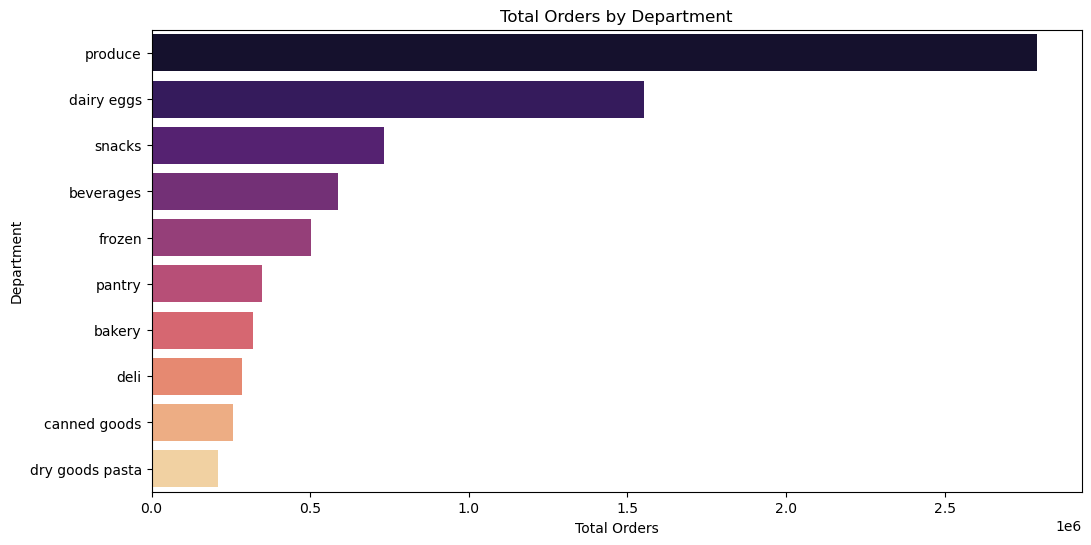

In [ ]:
# ===========================
# Bar Chart: Orders by Department
# ===========================

# Data from previous query (Department, Total Orders)
departments = ["produce", "dairy eggs", "snacks", "beverages", "frozen",
               "pantry", "bakery", "deli", "canned goods", "dry goods pasta"]
total_orders = [2792150, 1552847, 734152, 586406, 503483, 346797, 319346, 286003, 256307, 210654]

# Creating DataFrame
df_orders_by_department = pd.DataFrame({"Department": departments, "Total Orders": total_orders})

# Plotting Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Orders", y="Department", data=df_orders_by_department, palette="magma")
plt.xlabel("Total Orders")
plt.ylabel("Department")
plt.title("Total Orders by Department")
plt.show()


### Insights

- Produce is the most ordered department with ~2.79 million orders. This aligns with the earlier Top Ordered Products (bananas, avocados, berries). On another hand, Fresh produce is frequently bought and likely reordered often.
- Dairy & Eggs ranks second with 1.55 million orders. This reinforces the high reorder rates for milk, yogurt, and eggs seen in previous queries.
- Snacks are the third most popular category (734K orders).
    - Expect chips, granola bars, and nuts to dominate.
- Beverages & Frozen Foods also have strong demand.
    - Beverages (~586K orders) likely include popular items like bottled water, juices, and coffee.
    - Frozen Foods (~503K orders) suggest customers stock up on frozen essentials.
- Pantry Staples, Bakery, and Deli also contribute significantly. It could likely contain bread, canned goods, and dry pasta.

## Most Popular Aisles

In [ ]:
query = f"""
SELECT aisle, COUNT(*) AS total_orders
FROM {database_name}.{table_name}
GROUP BY aisle
ORDER BY total_orders DESC
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Top 10 Aisles:")
for row in rows:
    print(row)


Top 10 Aisles:
('fresh fruits', 1126037)
('fresh vegetables', 1008801)
('packaged vegetables fruits', 514598)
('yogurt', 461728)
('packaged cheese', 282859)
('milk', 261155)
('water seltzer sparkling water', 195078)
('chips pretzels', 185713)
('soy lactosefree', 172270)
('bread', 163697)


/tmp/ipykernel_22/1125909416.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total Orders", y="Aisle", data=df_aisles, palette="coolwarm")


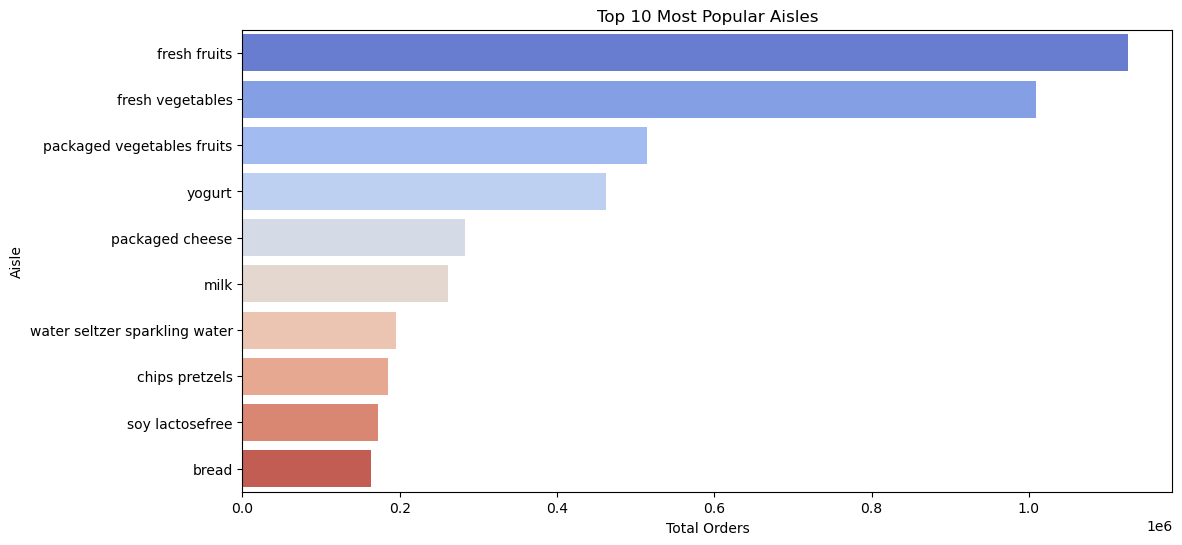

In [ ]:
# ===========================
# Bar Chart: Most Popular Aisles
# ===========================

# Data from previous query (Aisle, Total Orders)
aisles = ["fresh fruits", "fresh vegetables", "packaged vegetables fruits", "yogurt",
          "packaged cheese", "milk", "water seltzer sparkling water", "chips pretzels",
          "soy lactosefree", "bread"]
aisle_orders = [1126037, 1008801, 514598, 461728, 282859, 261155, 195078, 185713, 172270, 163697]

# Creating DataFrame
df_aisles = pd.DataFrame({"Aisle": aisles, "Total Orders": aisle_orders})

# Plotting Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Orders", y="Aisle", data=df_aisles, palette="coolwarm")
plt.xlabel("Total Orders")
plt.ylabel("Aisle")
plt.title("Top 10 Most Popular Aisles")
plt.show()

### Insights
- Fresh Produce Dominance:
    - Fresh Fruits (1.12M orders) and Fresh Vegetables (1.00M orders) are the top two aisles.
    - Combined, these two alone account for over 2 million orders, which reinforces why Produce is the top department.

- Dairy is Highly Popular:
    - Yogurt (461K orders) and Packaged Cheese (282K orders) show strong demand.
    - Milk (261K orders) further confirms that dairy products are household essentials.

- Beverages are a Major Category:
    - Water, Seltzer, and Sparkling Water (195K orders) ranks #7, showing strong demand for bottled drinks.

- Snacks & Bread are Key Pantry Items
    - Chips & Pretzels (185K orders) are among the most frequently purchased snacks.
    - Bread (163K orders) confirms why Bakery is among the top departments.

- Plant-Based Alternatives are Growing
    - Soy & Lactose-Free Products (172K orders) indicate increased demand for dairy-free alternatives.

##  Reorder Ratio by Department

In [ ]:
query = f"""
SELECT
    department,
    COUNT(*) AS total_orders,
    SUM(reordered) AS total_reorders,
    ROUND(100.0 * SUM(reordered) / COUNT(*), 2) AS reorder_ratio
FROM {database_name}.{table_name}
GROUP BY department
ORDER BY reorder_ratio DESC;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Reorder Ratio by Department:")
for row in rows:
    print(row)


Reorder Ratio by Department:
('dairy eggs', 1552847, 1283956, 82.68)
('beverages', 586406, 474261, 80.88)
('produce', 2792150, 2252168, 80.66)
('bakery', 319346, 256586, 80.35)
('deli', 286003, 224082, 78.35)
('snacks', 734152, 542890, 73.95)
('frozen', 503483, 361712, 71.84)
('canned goods', 256307, 167617, 65.4)
('dry goods pasta', 210654, 137594, 65.32)
('pantry', 346797, 198829, 57.33)


### Insights

- Dairy & Eggs Have the Highest Reorder Rate (82.68%)
    - Most frequently reordered category.
    - Milk, Yogurt, and Cheese are household staples → high repurchase behavior.

- Beverages Rank #2 in Reorders (80.88%)
    - Bottled Water, Sparkling Water, and Coffee/Tea are commonly repurchased.
    - These items are frequently consumed & replaced regularly.

- Produce Has a High Reorder Rate (80.66%)
    - Fruits and vegetables have a high purchase frequency.
    - Bananas, Avocados, and Berries from previous queries reinforce this trend.

- Bakery (80.35%) & Deli (78.35%) Show Strong Reorder Loyalty
    - Bread, Bagels, and Pre-packaged Deli Items are regularly bought items.
    - Customers often stick to the same brands.

- Snacks & Frozen Foods Have Moderate Reorder Rates (~70%)
    - Chips, Pretzels, and Frozen Meals are repurchased but less frequently than fresh foods.

- Canned Goods & Dry Goods Have Lower Reorder Rates (~65%)
    - Longer shelf life → not purchased as frequently.

- Pasta, sauces, and canned vegetables last longer → lower immediate repurchase need.

- Pantry Has the Lowest Reorder Rate (57.33%)
    - Less frequent purchases of pantry staples like flour, condiments, and spices.

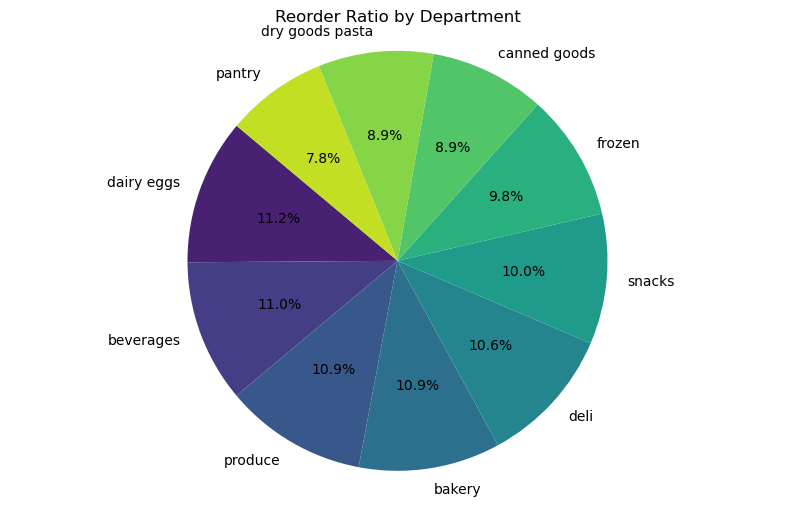

In [ ]:
# ===========================
# Pie Chart: Reorder Ratio by Department
# ===========================

# Data from previous query (Department, Reorder Ratio)
departments = ["dairy eggs", "beverages", "produce", "bakery", "deli",
               "snacks", "frozen", "canned goods", "dry goods pasta", "pantry"]
reorder_ratio = [82.68, 80.88, 80.66, 80.35, 78.35, 73.95, 71.84, 65.4, 65.32, 57.33]

# Create DataFrame
df_departments = pd.DataFrame({"Department": departments, "Reorder Ratio": reorder_ratio})

# Plot Pie Chart
plt.figure(figsize=(10, 6))
plt.pie(df_departments["Reorder Ratio"], labels=df_departments["Department"],
        autopct="%1.1f%%", colors=sns.color_palette("viridis", len(departments)), startangle=140)
plt.title("Reorder Ratio by Department")
plt.axis("equal")  # Equal aspect ratio ensures the pie is drawn as a circle
plt.show()

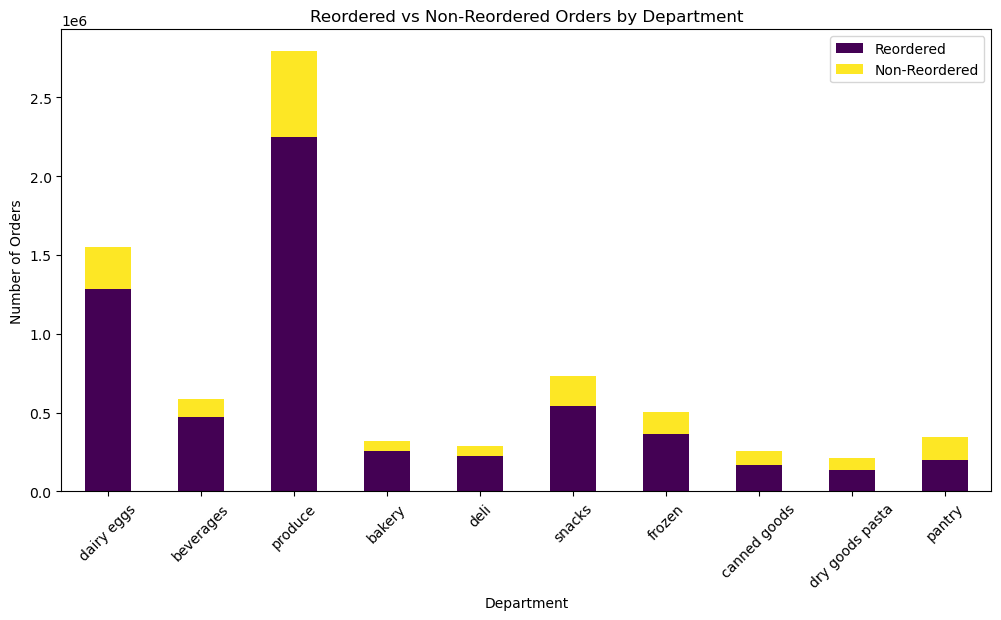

In [ ]:
# ===========================
# Stacked Bar Chart: Reordered vs Non-Reordered Orders by Department
# ===========================

# Data from previous query (Department, Reordered Orders)
departments = ["dairy eggs", "beverages", "produce", "bakery", "deli",
               "snacks", "frozen", "canned goods", "dry goods pasta", "pantry"]
total_orders = [1552847, 586406, 2792150, 319346, 286003, 734152, 503483, 256307, 210654, 346797]
reordered = [1283956, 474261, 2252168, 256586, 224082, 542890, 361712, 167617, 137594, 198829]
non_reordered = [total - reorder for total, reorder in zip(total_orders, reordered)]

# Create DataFrame
df_reorders = pd.DataFrame({"Department": departments, "Reordered": reordered, "Non-Reordered": non_reordered})

# Plot Stacked Bar Chart (Reordered vs Non-Reordered)
df_reorders.set_index("Department")[["Reordered", "Non-Reordered"]].plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.xlabel("Department")
plt.ylabel("Number of Orders")
plt.title("Reordered vs Non-Reordered Orders by Department")
plt.legend(["Reordered", "Non-Reordered"])
plt.xticks(rotation=45)
plt.show()

**Analysis for reordered vs non-reordered orders by department**:
    
1. Produce has the highest number of orders overall

    - Most of these orders are reorders, confirming that fruits and vegetables are frequently repurchased.

2. Dairy & Eggs have the highest reorder percentage
    - Consistently repurchased products like milk, cheese, and yogurt drive these numbers.

3. Snacks and Frozen Foods have moderate reorder levels
    - Customers repurchase snacks and frozen goods but at a slightly lower frequency than fresh items.

4. Pantry and Canned Goods have the lowest reorder rates
    - These products have a longer shelf life, reducing the need for frequent repurchasing.

## Correlation Analysis

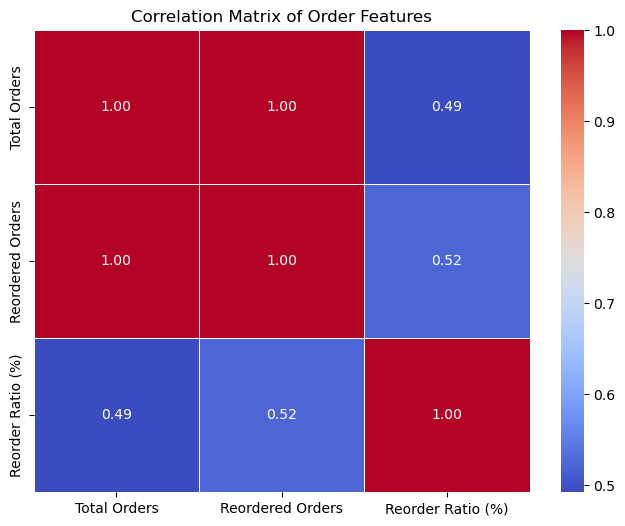

In [ ]:
# Data: Numerical Features for Correlation Analysis
departments = ["dairy eggs", "beverages", "produce", "bakery", "deli",
               "snacks", "frozen", "canned goods", "dry goods pasta", "pantry"]
total_orders = [1552847, 586406, 2792150, 319346, 286003, 734152, 503483, 256307, 210654, 346797]
reordered = [1283956, 474261, 2252168, 256586, 224082, 542890, 361712, 167617, 137594, 198829]
reorder_ratio = [82.68, 80.88, 80.66, 80.35, 78.35, 73.95, 71.84, 65.4, 65.32, 57.33]

# Creating DataFrame
df_correlation = pd.DataFrame({
    "Total Orders": total_orders,
    "Reordered Orders": reordered,
    "Reorder Ratio (%)": reorder_ratio
})

# Computing Correlation Matrix
correlation_matrix = df_correlation.corr()

# Plotting Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Order Features")
plt.show()


- Total Orders & Reordered Orders (Correlation = 1.00)
    - This confirms that departments with high total orders also have high reorders.
    - Produce, Dairy, and Beverages are likely contributing to this trend.

- Total Orders & Reorder Ratio (Correlation = 0.49)
    - Moderate positive correlation → Higher orders somewhat influence the reorder rate, but not always.
    - Some departments may have high first-time purchases but lower reorder rates (e.g., snacks, pantry items).

- Reordered Orders & Reorder Ratio (Correlation = 0.52)
    - A moderate correlation suggests that higher reorder volumes influence reorder ratio but not perfectly.
    - Some products (like dairy & produce) are reordered very frequently, while others (like pantry goods) less frequently.


# Feature Engineering

For creating ML Feature features, I am going to use the following labels:

- User ID: 	This tracks individual purchase behavior.
- Product ID: Helps identify frequently reordered products.
- Department ID: Some departments have higher reorder rates.
- Aisle ID: Aisle-level trends impact reorder likelihood.
- Total Orders: Highly correlated with reorder behavior.
- Reorder Ratio: Strong predictor of repeat purchases.
- Total items in Orders: 	Determines if larger orders influence reorders.
- User Order Frequency: Identifies frequent vs. occasional buyers.
- User Reorder Percentage: Determines likelihood of repeat purchases.
- Product popularity: Captures demand for the product.
- Department reorder ratio: Some departments have stronger reorder trends.
- Aisle Reorder ratio: Aisle-specific reorder behavior.
- Product Reorder trend:  Helps detect seasonal or trending products.


Strongest predictions for EDA:

1. Reorder Ratio: strongly correlated with reorders.
2. Total Orders: high correlation with reorder likelihood.
3. User Reorder percerntage: Helps preduct if a user is likely to reorder.
4. Product Popularity: popular items have higher reorders.
5. Department and Aisle reorder ratios: certain categories drive higher reorders.
